### Traffic simulation with OSMnx and UXsim
- [OSMnx](https://www.github.com/gboeing/osmnx)
- [UXsim](https://www.github.com/toruseo/uxsim)

In [63]:
import osmnx as ox
import random
import uxsim
from IPython.display import display, Image
import pickle

In [47]:
print (uxsim.__version__)

1.2.0


In [48]:
city_name = "Rotterdam"
surrounding_area_name = "South Holland"

In [49]:
road_network = ox.load_graphml("merged_network.graphml")

In [50]:
# Edge colors
color_map = {city_name: 'red', surrounding_area_name: 'blue'}
edge_colors = [color_map[road_network.edges[edge]['network']] for edge in road_network.edges]

# Generate a list of node populations to scale the node sizes for visualization
populations = [int(data['population_per_node']) for _, data in road_network.nodes(data=True)]
# Normalize
scaled_populations = [pop / max(populations) * 100 for pop in populations]

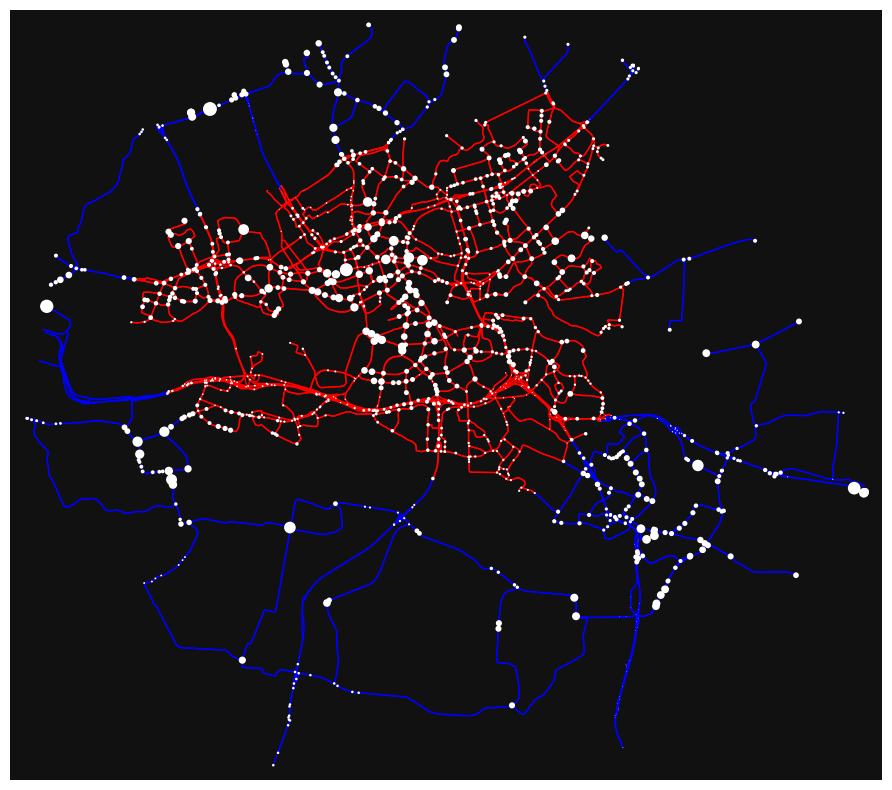

In [51]:
# The simplified_combined_network is now ready for further analysis or visualization
# Color edges based on the "network" attribute
fig, ax = ox.plot_graph(road_network, edge_color=edge_colors, node_size=scaled_populations, figsize=(12,10))

In [52]:
# Print number of nodes and edges
print(f"Number of nodes: {len(road_network.nodes)}\nNumber of edges: {len(road_network.edges)}")

Number of nodes: 1552
Number of edges: 3275


### UXsim model

In [53]:
# Initialize the simulation environment (World)

# Set simulation parameters
simulation_name = "MyUXsimWorld2"
simulation_duration = 7200  # in seconds (e.g., 3600 = 1 hour)
platoon_size = 25  # vehicles per platoon
reaction_time = 1  # in seconds
duo_update_time = 120  # in seconds, for dynamic user equilibrium (DUO) route choice update
duo_update_weight = 0.5  # weight for DUO update
duo_noise = 0.01  # noise for DUO route choice to prevent identical choices
eular_dt = 60  # in seconds, for Eulerian traffic state computation
eular_dx = 50  # in meters, for Eulerian traffic state computation
random_seed = 42  # for reproducibility

# Create the World object with the specified parameters
world = uxsim.World(name=simulation_name,
              deltan=platoon_size,
              reaction_time=reaction_time,
              duo_update_time=duo_update_time,
              duo_update_weight=duo_update_weight,
              duo_noise=duo_noise,
              eular_dt=eular_dt,
              eular_dx=eular_dx,
              random_seed=random_seed,
              print_mode=1,  # Enable printing simulation progress
              save_mode=1,  # Enable saving simulation results
              show_mode=0,  # Disable showing results via matplotlib (for faster performance)
              route_choice_principle="homogeneous_DUO",
              show_progress=1,  # Show simulation progress
              show_progress_deltat=300,  # Interval for showing progress, in seconds
              tmax=simulation_duration)  # Total simulation duration

In [54]:
# Helper function to determine max density based on road type and number of lanes
def calculate_max_density(road_type, network_name):
    default_density = 0.15  # Default maximum density in vehicles per meter per lane
    if network_name == surrounding_area_name:
        return 5  # We don't care about the density in the surrounding area
    if road_type in ['motorway', 'trunk']:
        return 0.07  # Lower density due to higher speeds and longer headways
    elif road_type in ['primary', 'secondary']:
        return 0.10
    elif road_type in ['residential', 'tertiary']:
        return 0.20  # Higher density due to lower speeds
    else:
        return default_density  # Default for unspecified or other road types

In [55]:
edges_with_data = road_network.edges(data=True)
# Get the network attribute for all edges
networks = [data['network'] for _, _, data in edges_with_data]
# Get the unique counts of network attributes
network_counts = {network: networks.count(network) for network in set(networks)}
network_counts

{'Rotterdam': 2481, 'South Holland': 794}

In [56]:
# Get the lanes attribute for all edges
lanes = [data.get('lanes', 1) for _, _, data in edges_with_data]
# Get the counts
# If lanes is a list, take the minimum value
lane_counts = {edge: min(data) if isinstance(data, list) else data for edge, data in enumerate(lanes)}
# Convert to int
lane_counts = {edge: int(data) for edge, data in lane_counts.items()}
# Get the unique counts of lanes
lane_counts = {lane: list(lane_counts.values()).count(lane) for lane in set(lane_counts.values())}
lane_counts

{1: 1812, 2: 1006, 3: 310, 4: 107, 5: 33, 6: 6, 7: 1}

In [57]:
# Create Nodes in UXsim from OSMnx graph nodes
for node_id, data in road_network.nodes(data=True):
    world.addNode(name=str(node_id), x=data['x'], y=data['y'])

# Create Links in UXsim from OSMnx graph edges
for u, v, data in road_network.edges(data=True):
    start_node_name = str(u)
    end_node_name = str(v)
    osmid = data['osmid']
    length = data['length']  # Assuming 'length' attribute exists
    # Assuming 'speed' attribute exists, convert speed from km/h to m/s
    speed_limit = data.get('speed', 30) * 1000 / 3600  # Default speed: 30 km/h
    # Calculate max density based on road type and lanes
    road_type = data.get('highway', '')
    network_name = data.get('network', '')
    max_density = calculate_max_density(road_type, network_name)
    priority = 1  # Example value
    # Get the lanes
    lanes = data.get('lanes', 1)
    # If lanes is a list, take the minimum value, and convert to int
    lanes = min(lanes) if isinstance(lanes, list) else lanes
    lanes = int(lanes)

    world.addLink(name=f"{u}_{v}_{osmid}", start_node=start_node_name, end_node=end_node_name, length=length, free_flow_speed=speed_limit, jam_density=max_density, merge_priority=priority, number_of_lanes=lanes)

In [58]:
# Assuming 'world' is your UXsim world and it has been populated with nodes and links as per previous steps
nodes = {node.name: node for node in world.NODES}  # List of node names

chance_on_trip = 0.08
chance_on_platoon = chance_on_trip / platoon_size

for orig_node, node in nodes.items():
    # Exclude the origin node from potential destinations
    potential_dests = list(nodes.keys() - {orig_node})
    
    n_trips = round(int(road_network.nodes[int(orig_node)]["population_per_node"]) * chance_on_platoon)
    
    for _ in range(n_trips):  # Create n trips from each node
        dest_node = random.choice(potential_dests)  # Randomly choose a destination
        departure_time = random.uniform(0, simulation_duration*0.5)  # Random departure time within the first half of the simulation
        
        # Add a vehicle for this trip
        world.addVehicle(orig=orig_node, dest=dest_node, departure_time=departure_time)
print(f"Added {len(world.VEHICLES)} vehicles to the simulation")

Added 5032 vehicles to the simulation


In [59]:
# Finalize the scenario after adding all vehicles
world.finalize_scenario()

simulation setting:
 scenario name: MyUXsimWorld2
 simulation duration:	 7200 s
 number of vehicles:	 125800 veh
 total road length:	 2199506.870429024 m
 time discret. width:	 25 s
 platoon size:		 25 veh
 number of timesteps:	 288
 number of platoons:	 5032
 number of links:	 3275
 number of nodes:	 1552
 setup time:		 3.01 s
simulating...


In [60]:
# Run the simulation to completion
while world.check_simulation_ongoing():
    world.exec_simulation(duration_t=simulation_duration)

      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.02 s
     300 s|    10275 vehs|   6.6 m/s|    79.22 s
     600 s|    20575 vehs|   6.3 m/s|   138.38 s
     900 s|    29300 vehs|   6.4 m/s|   197.74 s
    1200 s|    37925 vehs|   5.8 m/s|   258.36 s
    1500 s|    45975 vehs|   5.8 m/s|   320.27 s
    1800 s|    53900 vehs|   5.6 m/s|   379.39 s
    2100 s|    61825 vehs|   5.4 m/s|   442.92 s
    2400 s|    70250 vehs|   5.1 m/s|   506.79 s
    2700 s|    78200 vehs|   4.8 m/s|   573.47 s
    3000 s|    86025 vehs|   4.7 m/s|   641.31 s
    3300 s|    93500 vehs|   4.5 m/s|   714.74 s
    3600 s|   100650 vehs|   4.2 m/s|   788.00 s
    3900 s|    98650 vehs|   4.1 m/s|   856.69 s
    4200 s|    96150 vehs|   4.1 m/s|   928.37 s
    4500 s|    93900 vehs|   4.1 m/s|  1003.97 s
    4800 s|    91525 vehs|   4.1 m/s|  1077.44 s
    5100 s|    89225 vehs|   4.1 m/s|  1150.57 s
    5400 s|    86050 vehs|   4.0 m/s|  1224.22 s
    5700 s|   

In [61]:
# Generate the animation with a resolution of platoon size (25) * timestep_skip (12) = 300 seconds
# This means each frame in the animation represents the network state at a specific 25-second interval
world.analyzer.network_anim(animation_speed_inverse=50, detailed=0, minwidth=0.5, maxwidth=8, left_handed=0, figsize=(12,12), node_size=2, network_font_size=1, timestep_skip=12)

# The above method call assumes default values for some parameters that you might want to adjust
# The `timestep_skip` parameter is set to 30, corresponding to the desired 30-second resolution

 generating animation...


  0%|          | 0/24 [00:00<?, ?it/s]

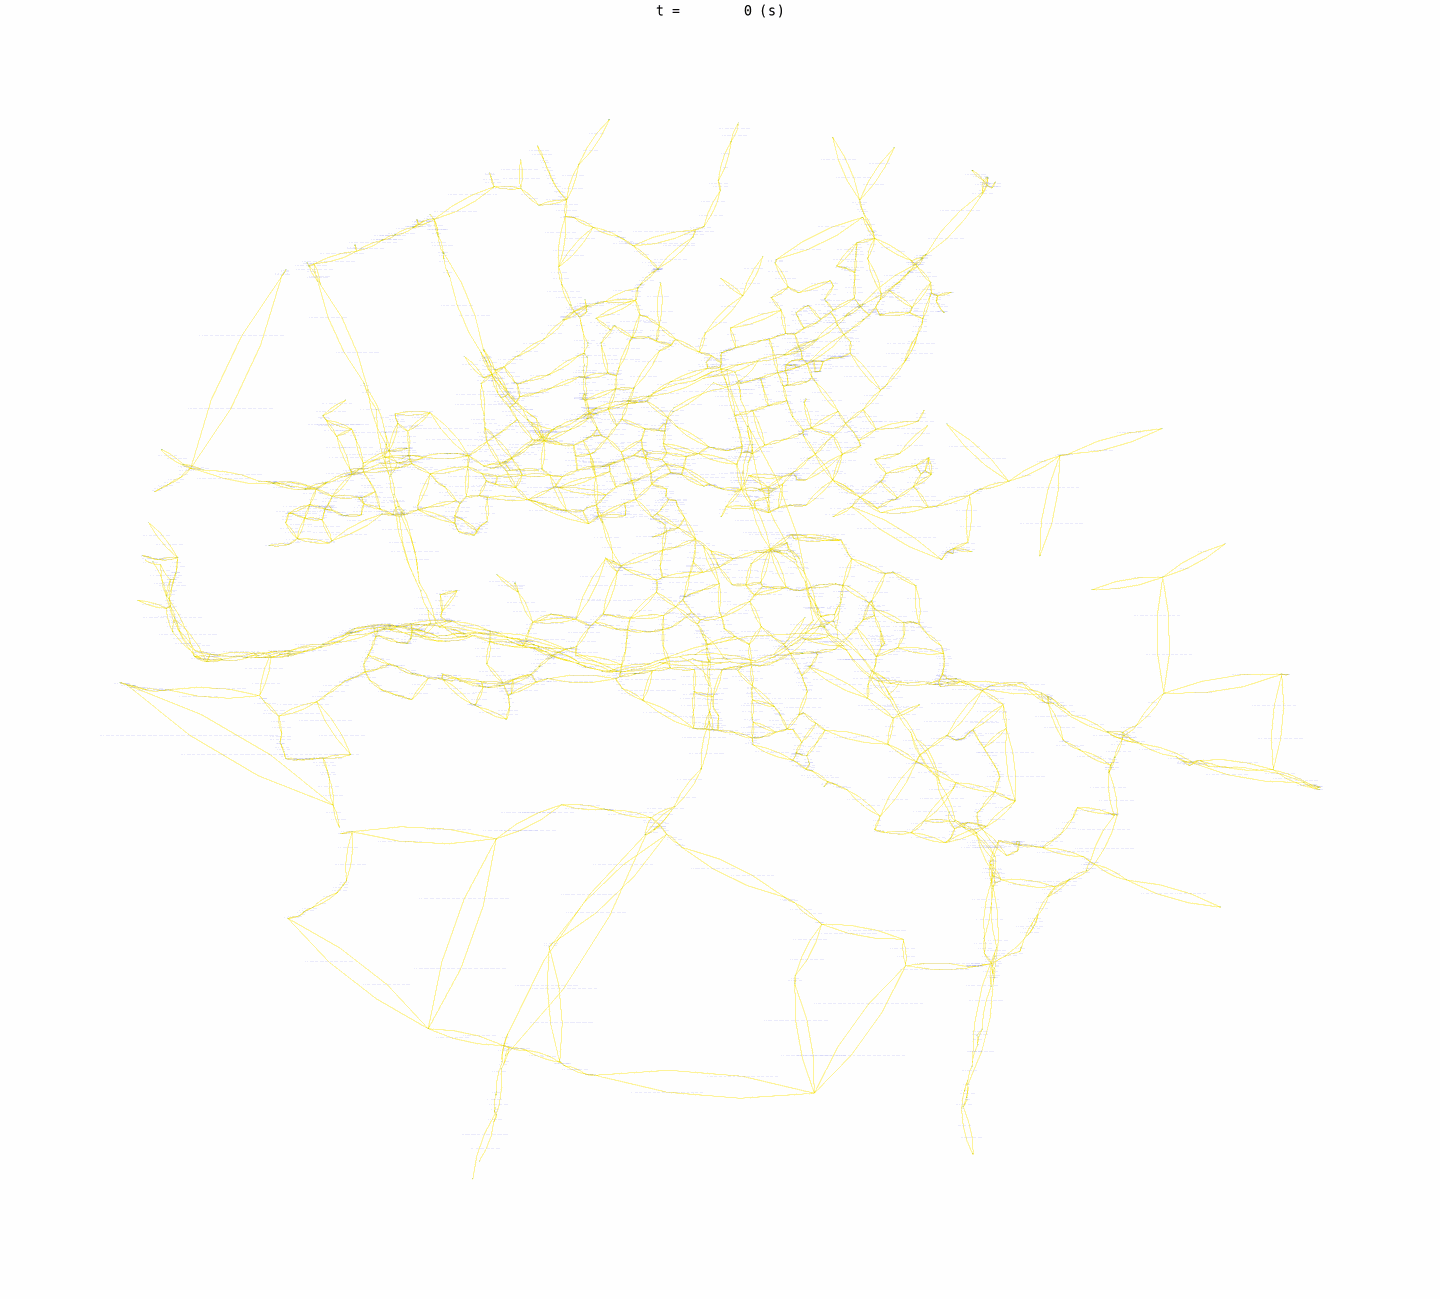

In [62]:
with open("outMyUXsimWorld2/anim_network0.gif", "rb") as f:
    display(Image(data=f.read(), format='gif'))

In [66]:
# Save the world as a pickle file in the runs folder
with open("runs/run1.pickle", "wb") as f:
    pickle.dump(world, f)

RecursionError: maximum recursion depth exceeded while pickling an object